In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import networkx as nx
import dgl
from cycler import cycler
from umap import UMAP
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from graph_env.environ import GraphEnv
from graph_env.agent import DQN, train, eval, noise_decay

/Users/williamarliss/Desktop/school/STAT-8289/rlenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/williamarliss/Desktop/school/STAT-8289/rlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
plt.rcdefaults()
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'w'
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams['font.family'] = 'arial'

In [3]:
### Configuration ###

### Environment/Graph ###
n_components = None
num_communities = 10
# num_communities = 5
n_iter_no_change = 10
max_iter = 100
# min_change = 0.001
# min_change = 0.002
# min_change = 0.0025
min_change = 0.003

### Agent ###
hidden_dim = 200
eta = 0.0001
mem_size = 1028
num_eval_episodes = 10
save_path = './model_synth_1'

### Training ###
burn_in = 256
train_steps = 9
update_freq = 3
batch_size = 16
gamma = 0.9
tau = 0.01
exploration_rate = 0.999
exploration_decay = 5e-5
num_episodes = 1_000


In [4]:
# expl = float(exploration_rate)
# n_eps = int(num_episodes)
# gamma = float(exploration_decay)
# trace = []
# for episode in range(n_eps):
#     expl = noise_decay(expl, episode, gamma)
#     trace.append(expl)
# plt.plot(trace);
# del expl, n_eps, gamma, trace, episode

In [5]:
B = np.array([
    [0.55, 0.05, 0.05, 0.05, 0.05],
    [0.05, 0.55, 0.05, 0.05, 0.05],
    [0.05, 0.05, 0.55, 0.05, 0.05],
    [0.05, 0.05, 0.05, 0.55, 0.05],
    [0.05, 0.05, 0.05, 0.05, 0.55],
])
n = np.random.poisson(50, size=5)
G = nx.stochastic_block_model(
    sizes=n,
    p=B,
    seed=0,
    directed=False,
    selfloops=False,
)
graph = dgl.from_networkx(G)
graph.ndata['label'] = torch.tensor([v for k, v in G.nodes(data='block')])
del B, n, G

In [6]:
env = GraphEnv(graph, num_communities=num_communities,
               n_iter_no_change=n_iter_no_change, max_iter=max_iter, min_change=min_change)
adapter = env.get_adapter()

In [29]:
agent = DQN(
    adapter,
    hidden_dim=hidden_dim,
    eta=eta,
    mem_size=mem_size,
)

---
### Training

In [8]:
preds, eval_history = eval(env, agent, num_episodes=num_eval_episodes, verbose=False)
np.mean([env.compute_modularity(p) for p in preds])

/Users/williamarliss/Desktop/school/STAT-8289/rl-final/graph_env/agent.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([


0.2801594704389572

In [9]:
train_history = train(
    env=env,
    agent=agent,
    burn_in=burn_in,
    train_steps=train_steps,
    update_freq=update_freq,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau,
    exploration_rate=exploration_rate,
    exploration_decay=exploration_decay,
    num_episodes=num_episodes,
    verbose=True,
    save_path=save_path,
)

/Users/williamarliss/Desktop/school/STAT-8289/rl-final/graph_env/agent.py:269: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 1 0.06428864598274231 0.999
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 2 0.04984163120388985 0.999
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 3 0.06028033420443535 0.999
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 4 0.08359333872795105 0.9988501724741288
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 5 0.07916043698787689 0.9986504423856517
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 6 0.07348871231079102 0.9984008421751078
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 7 0.061281293630599976 0.9981014117515824
|||||||||||||||||||||||||||||||||||||||||||||||||||

In [31]:
# train_history = pd.read_csv(os.path.join(save_path, 'history.csv'))

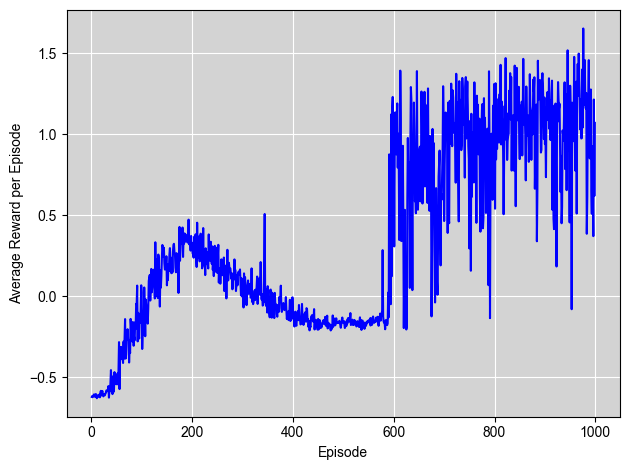

In [10]:
train_history.groupby('episode')['reward'].mean().plot();
plt.ylabel('Average Reward per Episode')
# train_history.groupby('episode')['reward'].sum().plot();
# plt.ylabel('Total Reward per Episode')
plt.xlabel('Episode')
plt.tight_layout()
plt.show()

In [11]:
# train_history.groupby('episode')['exploration'].mean().plot();
# plt.ylabel('Exploration Rate per Episode')
# plt.xlabel('Episode')
# plt.tight_layout()
# plt.show()

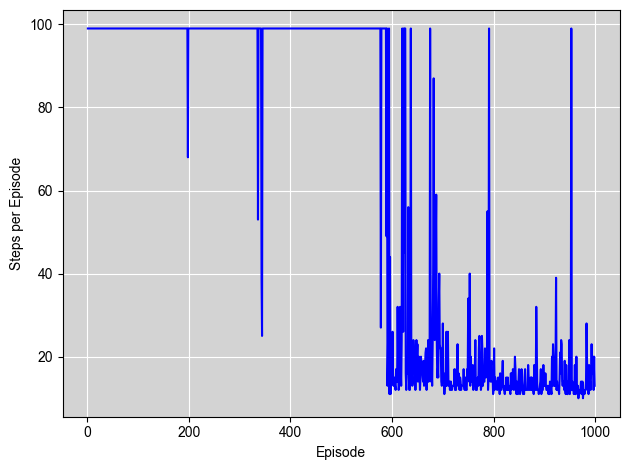

In [12]:
train_history.groupby('episode').size().plot();
plt.ylabel('Steps per Episode')
plt.xlabel('Episode')
plt.tight_layout()
plt.show()

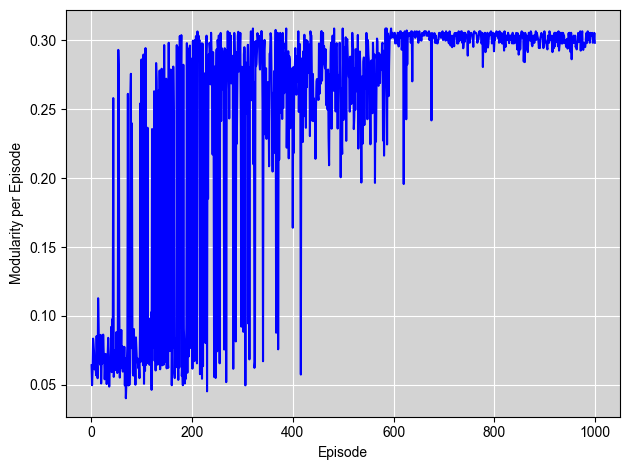

In [13]:
train_history.groupby('episode')['modularity'].apply(lambda x: list(x)[-1]).plot();
plt.ylabel('Modularity per Episode')
plt.xlabel('Episode')
plt.tight_layout()
plt.show()

---
### Evaluation

In [30]:
agent.load(save_path)

In [15]:
preds, eval_history = eval(env, agent, num_episodes=10, verbose=False)
np.mean([env.compute_modularity(p) for p in preds])

/Users/williamarliss/Desktop/school/STAT-8289/rl-final/graph_env/agent.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([


0.3035545080900192

In [16]:
lab = graph.ndata['label'].numpy()
env.compute_modularity(lab)

0.3084520697593689

In [17]:
pred = max(preds, key=lambda p: env.compute_modularity(p))
env.compute_modularity(pred)

0.3064013719558716

In [18]:
adjacency_matrix = graph.adj().to_dense().numpy()
degree_matrix = np.diag(adjacency_matrix.sum(1))
laplacian_matrix = degree_matrix - adjacency_matrix
laplacian_matrix = csr_matrix(laplacian_matrix)
del adjacency_matrix, degree_matrix

In [19]:
reducer = UMAP(n_components=2, n_neighbors=10, random_state=42)
embedding = reducer.fit_transform(laplacian_matrix)

/Users/williamarliss/Desktop/school/STAT-8289/rlenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


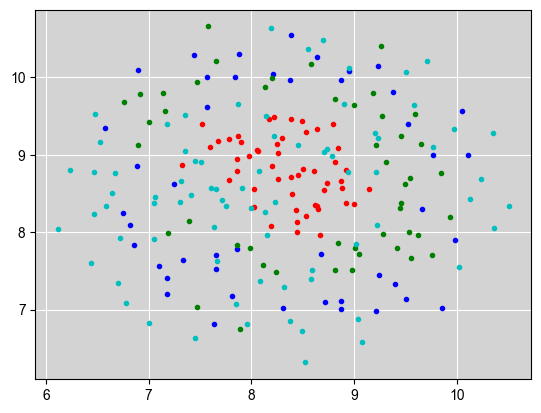

In [20]:
for p in np.unique(pred):
    plt.plot(*embedding[pred==p].T, '.')
plt.show()

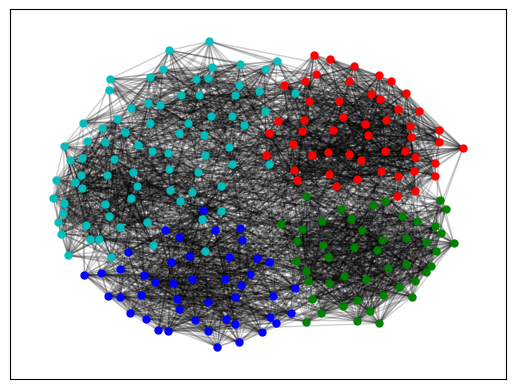

In [21]:
# pos = {i: embedding[i] for i in range(graph.num_nodes())}
colors = 'bgrcmy'
G = nx.Graph(graph.to_networkx())
pos = nx.kamada_kawai_layout(G)
plt.rcdefaults() #
fig, ax = plt.subplots()
nx.draw_networkx_edges(G, pos=pos, alpha=0.2, ax=ax)
for i, p in enumerate(np.unique(pred)):
    nx.draw_networkx_nodes(G.subgraph(np.where(pred==p)[0]), pos=pos, ax=ax, node_size=25, node_color=colors[i], alpha=0.99)

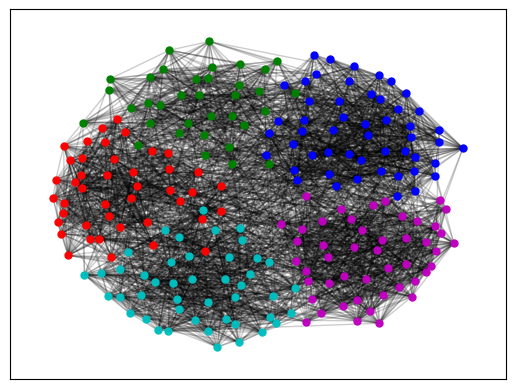

In [22]:
colors = 'bgrcmy'
G = nx.Graph(graph.to_networkx())
plt.rcdefaults() #
fig, ax = plt.subplots()
nx.draw_networkx_edges(G, pos=pos, alpha=0.2, ax=ax)
for i, l in enumerate(np.unique(lab)):
    nx.draw_networkx_nodes(G.subgraph(np.where(lab==l)[0]), pos=pos, ax=ax, node_size=25, node_color=colors[i], alpha=0.99)

---
### Baseline

In [23]:
G = graph.to_networkx()

In [24]:
louvain = np.zeros(graph.num_nodes(), dtype=int)
for idx, comm in enumerate(nx.community.louvain_communities(G, resolution=1)):
    for node in comm:
        louvain[node] = idx
idx

4

In [25]:
env2 = GraphEnv(env.graph, num_communities=idx+1)
env2.compute_modularity(louvain)

0.3084520697593689

---